In [1]:
# =======
# imports
# =======
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import os

The goal is to determine how many people will have off-grid electricity access. We use the Willingness To Pay (WTP) projections, and the LCOE raster layers from Szabo. In any given year a raster cell will be given access if $WTP \le min_t(LCOE)$, where $t$ spans over the off-grid technologies in the LCOE rasters.  

We will accomplish this through the following steps: 

1. Create WTP raster layers (one per year)

2. Create energy access raster layers

3. Count nr of connected people per country


# WTP raster layers

In this step we create five new raster layers. The composition of each layer will be as follows:
- one layer per decadal point between 2010 and 2050;

- each layer will contain a rasterized map of Africa (same resolution and crs as other rasters in the analysis);

- each cell within each country will be assigned the WTP corresponding to that country in that year;

- naming convention will be wtp_y.tiff, with y = [2010, 2020, 2030, 2040, 2050].

We create the WTP raster layers following these steps: 

1. Make a copy of \u{vector} layer with country boundaries (country_vec.shp);

2. Using GeoPandas add columns with WTP per country and year to the attribute table, and save as a new vector layer (wtp_vec.shp); 

3. In QGIS rasterize the shapefile 5 times, each time selecting the WTP column for a particular year --> output will be 5 wtp_y.tiff raster layers. 

## Copy country boundaries
Copy created in C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR\\gis_layers\\off-grid_access

In [2]:
gis_dir = "C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR_alt\\gis_layers\\off-grid_access"

## Add WTP data to attribute table

In [3]:
wtp_vec = gpd.read_file(gis_dir+"\\country_vec.shp")
wtp_vec.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,geometry
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


In [10]:
# WTP projections in $/MWh
data_dir = "C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR_alt\\code"
wtp_data = pd.read_excel(data_dir+"\\wtp_projections.xlsx", sheet_name="data",\
                         dtype={'COUNTRY':str,'wtp-2010':np.int32,'wtp-2020':np.int32,'wtp-2030':np.int32,
                                'wtp-2040':np.int32,'wtp-2050':np.int32})
wtp_data.head()

,Country Name,2010,2020,2030,2040,2050,2060,2070,2080,2090,...,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,wtp-2070,wtp-2080,wtp-2090,wtp-2100
0,Algeria,142.503476,168.762262,204.155374,243.925254,283.439547,323.684631,367.503597,416.244984,470.879883,...,142,168,204,243,283,323,367,416,470,532
1,Angola,142.503476,177.045603,233.369760,299.376714,366.316986,433.087256,499.862793,570.837433,648.428726,...,142,177,233,299,366,433,499,570,648,734
2,Benin,132.393921,175.587732,225.868191,278.222003,337.858277,406.771476,477.694459,550.285939,627.812758,...,132,175,225,278,337,406,477,550,627,712
3,Botswana,81.467298,98.368157,117.867478,144.225763,170.839381,198.133770,227.143225,258.517970,293.159712,...,81,98,117,144,170,198,227,258,293,331
4,Burkina Faso,23.576186,31.267968,40.221714,49.544673,60.164465,72.436255,85.065939,97.992742,111.798411,...,23,31,40,49,60,72,85,97,111,126


In [11]:
# check that all countries are there
match = []
no_match = []
for c in wtp_vec.COUNTRY.unique(): 
    try: 
        wtp_data[wtp_data['COUNTRY']==c]['COUNTRY'].values[0]
        match.append(c)
    except(IndexError):
        no_match.append(c)

In our WTP dataset we miss the following three countries. We can assing to Western Sahara the same WTP as Morocco, and 0 to the other two (very small). 

In [12]:
no_match

['Cape Verde', 'Guinea Bissau', 'Western Sahara']

In [13]:
wtp_vec = wtp_vec.merge(wtp_data, on='COUNTRY', how='left')
wtp_vec.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,geometry,Country Name,...,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,wtp-2070,wtp-2080,wtp-2090,wtp-2100
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,"POLYGON ((1894589.42156076 6093196.823427028, ...",Algeria,...,142.0,168.0,204.0,243.0,283.0,323.0,367.0,416.0,470.0,532.0
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,"POLYGON ((3809405.5247603 2283690.127493567, 3...",Angola,...,142.0,177.0,233.0,299.0,366.0,433.0,499.0,570.0,648.0,734.0
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,"POLYGON ((3744504.513407562 2674551.841173306,...",Angola,...,142.0,177.0,233.0,299.0,366.0,433.0,499.0,570.0,648.0,734.0
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,"POLYGON ((3650051.721446254 1343900.192709396,...",Angola,...,142.0,177.0,233.0,299.0,366.0,433.0,499.0,570.0,648.0,734.0
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,"POLYGON ((3755607.506678306 2543061.0734161, 3...",Angola,...,142.0,177.0,233.0,299.0,366.0,433.0,499.0,570.0,648.0,734.0


In [14]:
wtp_vec[wtp_vec['wtp-2010'].isnull()]

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,geometry,Country Name,...,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,wtp-2070,wtp-2080,wtp-2090,wtp-2100
26,27,CAP,Cape Verde,Cape Verde,West Africa,1001.000000,1.956680e+05,195.472527,POLYGON ((-74241.23970159236 4984908.892225869...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,28,CAP,Cape Verde,Cape Verde,West Africa,770.000000,1.504810e+05,195.429870,"POLYGON ((-190844.984160699 5252850.151119065,...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,29,CAP,Cape Verde,Cape Verde,West Africa,635.000000,1.174040e+05,184.888189,"POLYGON ((14934.91457329132 5128139.14834156, ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,30,CAP,Cape Verde,Cape Verde,West Africa,476.000000,9.244800e+04,194.218487,POLYGON ((-157997.8524104496 4987231.392490668...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,31,CAP,Cape Verde,Cape Verde,West Africa,350.000000,6.634100e+04,189.545714,"POLYGON ((-129289.3360763937 5187121.76210235,...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,32,CAP,Cape Verde,Cape Verde,West Africa,282.000000,5.364300e+04,190.223404,POLYGON ((-38398.80535238609 5025013.132684402...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,33,CAP,Cape Verde,Cape Verde,West Africa,238.000000,4.298800e+04,180.621849,POLYGON ((-185544.4271485256 5222889.070809429...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,34,CAP,Cape Verde,Cape Verde,West Africa,224.000000,4.054300e+04,180.995536,"POLYGON ((13701.47250644304 5202207.455821854,...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,35,CAP,Cape Verde,Cape Verde,West Africa,66.000000,1.249300e+04,189.287879,POLYGON ((-198447.3155713473 4975947.476573421...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,36,CAP,Cape Verde,Cape Verde,West Africa,36.000000,6.440000e+03,178.888889,"POLYGON ((-171426.0420856401 5206767.97814951,...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# fix Western Sahara
wtp_vec.loc[wtp_vec[wtp_vec.COUNTRY=='Western Sahara'].index,'Country Name':] =\
wtp_vec.loc[wtp_vec[wtp_vec.COUNTRY=='Morocco'].index,'Country Name':].values

wtp_vec[wtp_vec.COUNTRY=='Western Sahara']

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,geometry,Country Name,...,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,wtp-2070,wtp-2080,wtp-2090,wtp-2100
759,760,WES,Western Sahara,Western Sahara,West Africa,268032.0,44957627.0,167.732312,"POLYGON ((1278996.469634898 6164782.517533207,...",Morocco,...,139.0,166.0,201.0,240.0,280.0,319.0,363.0,411.0,465.0,525.0


In [16]:
# Fix Guinea Bissau
wtp_vec.loc[wtp_vec[wtp_vec.COUNTRY=='Guinea Bissau'].index,'Country Name':] =\
wtp_vec.loc[wtp_vec[wtp_vec.COUNTRY=='Guinea-Bissau'].index,'Country Name':].values

wtp_vec[wtp_vec.COUNTRY=='Guinea Bissau']

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,geometry,Country Name,...,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,wtp-2070,wtp-2080,wtp-2090,wtp-2100
373,374,GUB,Guinea Bissau,Guinea Bissau,West Africa,32283.000000,6.314185e+06,195.588545,"POLYGON ((755532.027747611 4593096.508572872, ...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
374,375,GUB,Guinea Bissau,Guinea Bissau,West Africa,293.000000,6.454900e+04,220.303754,"POLYGON ((636221.905124451 4495006.132465357, ...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
376,377,GUB,Guinea Bissau,Guinea Bissau,West Africa,137.000000,2.939700e+04,214.576642,"POLYGON ((657917.3543985998 4539663.970458589,...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
377,378,GUB,Guinea Bissau,Guinea Bissau,West Africa,130.000000,2.835000e+04,218.076923,"POLYGON ((615819.5214287709 4545625.169818313,...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
378,379,GUB,Guinea Bissau,Guinea Bissau,West Africa,111.000000,2.433300e+04,219.216216,"POLYGON ((669899.0799147538 4505721.585016444,...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
379,380,GUB,Guinea Bissau,Guinea Bissau,West Africa,105.000000,2.297900e+04,218.847619,"POLYGON ((652604.2324893526 4499193.599088431,...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
380,381,GUB,Guinea Bissau,Guinea Bissau,West Africa,112.000000,2.329800e+04,208.017857,"POLYGON ((626751.673425734 4596106.602121683, ...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
381,382,GUB,Guinea Bissau,Guinea Bissau,West Africa,109.000000,2.401200e+04,220.293578,"POLYGON ((630023.1159054856 4522588.018211004,...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
382,383,GUB,Guinea Bissau,Guinea Bissau,West Africa,102.000000,2.123900e+04,208.225490,"POLYGON ((698483.4187932438 4556418.907686535,...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0
383,384,GUB,Guinea Bissau,Guinea Bissau,West Africa,94.000000,2.060800e+04,219.234043,"POLYGON ((641610.4743873547 4498717.404525348,...",Guinea-Bissau,...,23.0,31.0,40.0,49.0,59.0,72.0,84.0,97.0,111.0,126.0


In [17]:
# Fix Cape Verde
wtp_vec.loc[wtp_vec[wtp_vec.COUNTRY=='Cape Verde'].index,'Country Name':] = 0

wtp_vec[wtp_vec.COUNTRY=='Cape Verde']

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,geometry,Country Name,...,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,wtp-2070,wtp-2080,wtp-2090,wtp-2100
26,27,CAP,Cape Verde,Cape Verde,West Africa,1001.0,195668.0,195.472527,POLYGON ((-74241.23970159236 4984908.892225869...,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,28,CAP,Cape Verde,Cape Verde,West Africa,770.0,150481.0,195.429870,"POLYGON ((-190844.984160699 5252850.151119065,...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,29,CAP,Cape Verde,Cape Verde,West Africa,635.0,117404.0,184.888189,"POLYGON ((14934.91457329132 5128139.14834156, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,30,CAP,Cape Verde,Cape Verde,West Africa,476.0,92448.0,194.218487,POLYGON ((-157997.8524104496 4987231.392490668...,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,31,CAP,Cape Verde,Cape Verde,West Africa,350.0,66341.0,189.545714,"POLYGON ((-129289.3360763937 5187121.76210235,...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,32,CAP,Cape Verde,Cape Verde,West Africa,282.0,53643.0,190.223404,POLYGON ((-38398.80535238609 5025013.132684402...,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,33,CAP,Cape Verde,Cape Verde,West Africa,238.0,42988.0,180.621849,POLYGON ((-185544.4271485256 5222889.070809429...,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,34,CAP,Cape Verde,Cape Verde,West Africa,224.0,40543.0,180.995536,"POLYGON ((13701.47250644304 5202207.455821854,...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,35,CAP,Cape Verde,Cape Verde,West Africa,66.0,12493.0,189.287879,POLYGON ((-198447.3155713473 4975947.476573421...,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,36,CAP,Cape Verde,Cape Verde,West Africa,36.0,6440.0,178.888889,"POLYGON ((-171426.0420856401 5206767.97814951,...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# check
wtp_vec[wtp_vec['wtp-2010'].isnull()].ID

Series([], Name: ID, dtype: object)

In [19]:
# change type to integer
wtp_vec = pd.concat([wtp_vec.loc[:,:'Country Name'], wtp_vec.loc[:,'wtp-2010':].astype(np.int32, errors='ignore')], axis=1)
wtp_vec.dtypes

ID               object
CODE             object
COUNTRY          object
CNTRY            object
REGION           object
countrycou      float64
countrysum      float64
countrymea      float64
geometry         object
Country Name     object
wtp-2010          int32
wtp-2020          int32
wtp-2030          int32
wtp-2040          int32
wtp-2050          int32
wtp-2060          int32
wtp-2070          int32
wtp-2080          int32
wtp-2090          int32
wtp-2100          int32
dtype: object

In [20]:
# Export
wtp_vec.to_file(gis_dir+"\\wtp_vec.shp")

## Rasterize
This step is done in QGIS (raster --> conversion --> rasterize).

# Off-grid access rasters

In this step we create for each year in the range 2010 - 2050 a raster layer containing in each pixel 1 if there is at least one off-grid technology which has LCOE < WTP, and 0 otherwise. 

We have three LCOE raster layers from Szabo, One for solar PV, one for hydro and one for diesel generators (in the future we may add more if they become available, e.g. it would be nice to also have wind). The costs in these layers are for the year 2010. We first need to project them to 2020 - 2050. Following our cost assumptions, PV is the only technology among the three that will experience significant cost reductions in the future (the other two are mostly mature). Hence we first create an extra set of PV LCOE layers for the years 2020 - 2050, decreasing the LCOE according to our cost-reduction assumptions. Then for each year we check whether the WTP is higher than any of the off-grid LCOEs, and save result as a new (binary) layer (naming convention: access_y.tif). 

This is all done in QGIS using the raster calculator. PV cost reduction factors:

- 2020/2010: 87%

- 2030/2010: 70%

- 2040/2010: 57%

- 2050/2010: 46%

Raster Calculator expresion for determining whether there is access: 

( "di9@1" > 0 AND "hy9@1" > 0 AND "pv_2010@1" > 0 AND "wtp_2010@1" > 0 ) *
( "wtp_2010@1" >= "di9@1"  OR "wtp_2010@1" >= "hy9@1" OR "wtp_2010@1" >= "pv_2010@1" ), 

where: 

- di9.tif: derived from original di_ptj.tif by first saving as di.tif specifying same extent as wtp_2010, then change 0s to 99999 using the raster calculator (("di@1"=0)\*99999 + (di@1!=0)\*"di@1").

- hy9.tif: derived from original hydro_i1.tif by first unchecking "no data value"in the properties --> style menu, than changing 255s into 99999 with the raster calculator;

- pv_2010.tif: defined above;

- wtp_2010.tif: defined above. 

This results in a raster layer that has 1 where there is at least one technology with LCOE below the WTP. Repeat for other years. 

# Fraction of population per country that can afford off-grid access

Our goal is to count how many people there are in each country in the areas where off-grid access was calculated as affordable. We achieve this with the following steps:

1. In QGIS we take the raster population layer pp_afr.tif and we save it using the same projection as the wtp_y layers --> pop_prj.tif. Turn the negative values (NoDataValue) to zeros using the raster calculator, and align it to the access_y rasters using Raster --> Align Rasters.

2. In the Raster calculator we multiply by access_y to obtain 5 access_pop_y layers. 

3. Run Zonal Statistics on pop_prj and on the 5 new rasters, summing the values of the pixels in each polygon of wtp_vec, and also counting the pixels in each poygon.

4. Import wtp_vec in geopandas, do some checks and renormalizations, and aggregate by country. 


In [16]:
wtp = gpd.read_file(gis_dir+"\\wtp_vec.shp")
wtp.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,Country Na,wtp-2010,...,pop2010s_1,pop2010c_2,pop2010s_2,pop2010c_3,pop2010s_3,pop2010c_4,pop2010s_4,pop_count,pop_sum,geometry
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,Algeria,142,...,24938644.0,2325210.0,25003877.0,2325210.0,25050021.0,2325210.0,25050021.0,2325210.0,25050021.0,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,Angola,142,...,14084087.0,1247523.0,15306265.0,1247523.0,15306265.0,1247523.0,15306412.0,1247523.0,15307500.0,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,Angola,142,...,209336.0,7152.0,214475.0,7152.0,214475.0,7152.0,214475.0,7152.0,214484.0,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,Angola,142,...,0.0,102.0,0.0,102.0,0.0,102.0,0.0,102.0,0.0,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,Angola,142,...,57.0,21.0,57.0,21.0,57.0,21.0,57.0,21.0,57.0,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


The last few columns are as follows: 

- 'pop2010sum': sum of pixel values in access_pop_2010 per polygon (same for other years)
- 'pop2010cou': count of pixels in access_pop_2010 per polygon (same for other years)
- 'bin2010sum': sum of pixel values in access_2010 per polygon (same for other years)
- 'bin2010cou': count of pixels in access_2010 per polygon (same for other years) 
- 'pop_count':  count of pixels in pop_prj_pos per polygon (same for other years)  
- 'pop_sum':    sum of pixel values in pop_prj_pos per polygon (same for other years)

Let's rename the columns using more meaningful names and rearrange their order:

In [17]:
# original cols
wtp.columns

Index(['ID', 'CODE', 'COUNTRY', 'CNTRY', 'REGION', 'countrycou', 'countrysum',
       'countrymea', 'Country Na', 'wtp-2010', 'wtp-2020', 'wtp-2030',
       'wtp-2040', 'wtp-2050', 'wtp-2060', 'wtp-2070', 'wtp-2080', 'wtp-2090',
       'wtp-2100', 'bin2010cou', 'bin2010sum', 'bin2020cou', 'bin2020sum',
       'bin2030cou', 'bin2030sum', 'bin2040cou', 'bin2040sum', 'bin2050cou',
       'bin2050sum', 'pop2010cou', 'pop2010sum', 'pop2010c_1', 'pop2010s_1',
       'pop2010c_2', 'pop2010s_2', 'pop2010c_3', 'pop2010s_3', 'pop2010c_4',
       'pop2010s_4', 'pop_count', 'pop_sum', 'geometry'],
      dtype='object')

In [18]:
# rename
# a - access layers
# pop - population (inhabitants per pixel)
# bin - binary (0/1)
# sum - sum values in pixels
# count - count pixels

new_colnames = list(wtp.columns[:19])+\
               ['a_bin_2010_count','a_bin_2010_sum','a_bin_2020_count','a_bin_2020_sum',\
                'a_bin_2030_count','a_bin_2030_sum','a_bin_2040_count','a_bin_2040_sum',\
                'a_bin_2050_count','a_bin_2050_sum',\
                'a_pop_2010_count','a_pop_2010_sum','a_pop_2020_count','a_pop_2020_sum',\
                'a_pop_2030_count','a_pop_2030_sum','a_pop_2040_count','a_pop_2040_sum',\
                'a_pop_2050_count','a_pop_2050_sum',\
                'pop_count', 'pop_sum', 'geometry']
wtp.columns = new_colnames
wtp.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,Country Na,wtp-2010,...,a_pop_2020_sum,a_pop_2030_count,a_pop_2030_sum,a_pop_2040_count,a_pop_2040_sum,a_pop_2050_count,a_pop_2050_sum,pop_count,pop_sum,geometry
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,Algeria,142,...,24938644.0,2325210.0,25003877.0,2325210.0,25050021.0,2325210.0,25050021.0,2325210.0,25050021.0,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,Angola,142,...,14084087.0,1247523.0,15306265.0,1247523.0,15306265.0,1247523.0,15306412.0,1247523.0,15307500.0,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,Angola,142,...,209336.0,7152.0,214475.0,7152.0,214475.0,7152.0,214475.0,7152.0,214484.0,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,Angola,142,...,0.0,102.0,0.0,102.0,0.0,102.0,0.0,102.0,0.0,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,Angola,142,...,57.0,21.0,57.0,21.0,57.0,21.0,57.0,21.0,57.0,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


In [19]:
# reorder (first all the sums then all the counts)
ordered_cols = list(wtp.columns[:19])+\
               ['a_pop_2010_sum','a_pop_2020_sum','a_pop_2030_sum','a_pop_2040_sum','a_pop_2050_sum',\
                'a_bin_2010_sum','a_bin_2020_sum','a_bin_2030_sum','a_bin_2040_sum','a_bin_2050_sum',\
                'pop_sum',\
                'a_pop_2010_count','a_pop_2020_count','a_pop_2030_count','a_pop_2040_count','a_pop_2050_count',\
                'a_bin_2010_count','a_bin_2020_count','a_bin_2030_count','a_bin_2040_count','a_bin_2050_count',\
                'pop_count',\
                'geometry']

wtp = wtp[ordered_cols]
wtp.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,Country Na,wtp-2010,...,a_pop_2030_count,a_pop_2040_count,a_pop_2050_count,a_bin_2010_count,a_bin_2020_count,a_bin_2030_count,a_bin_2040_count,a_bin_2050_count,pop_count,geometry
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,Algeria,142,...,2325210.0,2325210.0,2325210.0,2325210.0,2325210.0,2325210.0,2325210.0,2325210.0,2325210.0,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,Angola,142,...,1247523.0,1247523.0,1247523.0,1247523.0,1247523.0,1247523.0,1247523.0,1247523.0,1247523.0,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,Angola,142,...,7152.0,7152.0,7152.0,7152.0,7152.0,7152.0,7152.0,7152.0,7152.0,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,Angola,142,...,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,Angola,142,...,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


In [20]:
# check if all rasters contain the same number of pixel
counts = wtp.loc[:,wtp.columns.str.contains('_count')]
print(counts.sum())

a_pop_2010_count    3.006078e+07
a_pop_2020_count    3.006078e+07
a_pop_2030_count    3.006078e+07
a_pop_2040_count    3.006078e+07
a_pop_2050_count    3.006078e+07
a_bin_2010_count    3.006078e+07
a_bin_2020_count    3.006078e+07
a_bin_2030_count    3.006078e+07
a_bin_2040_count    3.006078e+07
a_bin_2050_count    3.006078e+07
pop_count           3.006078e+07
dtype: float64


In [21]:
# check per polygon
check = []
for i in range(len(counts.columns)):
    check.append(counts.iloc[:,0] == counts.iloc[:,i])
for c in check:
    print(c.sum() == len(c))

False
False
False
False
False
False
False
False
False
False
False


In [22]:
# Not all the same because there are some NaNs. Let's put them to zero and redo the check:
wtp = wtp.fillna(0)
wtp[wtp['a_pop_2010_count'] != wtp['pop_count']]

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,Country Na,wtp-2010,...,a_pop_2030_count,a_pop_2040_count,a_pop_2050_count,a_bin_2010_count,a_bin_2020_count,a_bin_2030_count,a_bin_2040_count,a_bin_2050_count,pop_count,geometry


In [23]:
counts = wtp.loc[:,wtp.columns.str.contains('_count')]
check = []
for i in range(len(counts.columns)):
    check.append(counts.iloc[:,0] == counts.iloc[:,i])
for c in check:
    print(c.sum() == len(c))

True
True
True
True
True
True
True
True
True
True
True


In [24]:
# create a summary per country
wtpc = wtp.groupby('COUNTRY').sum().reset_index()
wtpc.head()

,COUNTRY,countrycou,countrysum,countrymea,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,...,a_pop_2020_count,a_pop_2030_count,a_pop_2040_count,a_pop_2050_count,a_bin_2010_count,a_bin_2020_count,a_bin_2030_count,a_bin_2040_count,a_bin_2050_count,pop_count
0,Algeria,2.325210e+06,4.076058e+08,175.298471,142,168,204,243,283,323,...,2.325210e+06,2.325210e+06,2.325210e+06,2.325210e+06,2.325210e+06,2.325210e+06,2.325210e+06,2.325210e+06,2.325210e+06,2.325210e+06
1,Angola,1.254848e+06,2.503181e+08,-207849.857601,2556,3186,4194,5382,6588,7794,...,1.254848e+06,1.254848e+06,1.254848e+06,1.254848e+06,1.254848e+06,1.254848e+06,1.254848e+06,1.254848e+06,1.254848e+06,1.254848e+06
2,Benin,1.163010e+05,2.350732e+07,202.124814,132,175,225,278,337,406,...,1.163010e+05,1.163010e+05,1.163010e+05,1.163010e+05,1.163010e+05,1.163010e+05,1.163010e+05,1.163010e+05,1.163010e+05,1.163010e+05
3,Botswana,5.806660e+05,1.152753e+08,198.522476,81,98,117,144,170,198,...,5.806660e+05,5.806660e+05,5.806660e+05,5.806660e+05,5.806660e+05,5.806660e+05,5.806660e+05,5.806660e+05,5.806660e+05,5.806660e+05
4,Burkina Faso,2.750980e+05,4.958767e+07,180.254549,23,31,40,49,60,72,...,2.750980e+05,2.750980e+05,2.750980e+05,2.750980e+05,2.750980e+05,2.750980e+05,2.750980e+05,2.750980e+05,2.750980e+05,2.750980e+05


In [25]:
# Per country normalize population with access by total population (a_pop_year_sum / pop_prj)
wtp_norm = pd.DataFrame()
wtp_norm['COUNTRY'] = wtpc['COUNTRY']

sel_col = [c for c in wtpc.columns if 'a_pop' in c and '_sum' in c]
for c in sel_col:
    y = c.split('_')[2]
    wtp_norm.loc[:,'offgrid_access_'+y] = wtpc.loc[:,c] / wtpc.loc[:,'pop_sum']
wtp_norm

,COUNTRY,offgrid_access_2010,offgrid_access_2020,offgrid_access_2030,offgrid_access_2040,offgrid_access_2050
0,Algeria,0.995533,0.995554,0.998158,1.000000e+00,1.000000e+00
1,Angola,0.598203,0.920855,0.999920,9.999198e-01,9.999293e-01
2,Benin,0.000000,0.160925,0.998676,9.999985e-01,1.000000e+00
3,Botswana,0.000000,0.000000,0.000000,9.980772e-01,9.999776e-01
4,Burkina Faso,0.000000,0.000023,0.000023,2.262395e-05,5.214355e-05
5,Burundi,0.000000,0.000000,0.000000,2.949453e-04,2.949453e-04
6,Cameroon,0.000000,0.000008,0.810100,9.998382e-01,9.998382e-01
7,Cape Verde,NaN,NaN,NaN,NaN,NaN
8,Central African Republic,0.000000,0.000000,0.000011,1.141331e-05,1.141331e-05
9,Chad,0.000163,0.000224,0.003405,3.404915e-03,3.404915e-03


In [26]:
# checl that they are all < 1
(wtp_norm>1).sum()

COUNTRY                53
offgrid_access_2010     0
offgrid_access_2020     0
offgrid_access_2030     0
offgrid_access_2040     0
offgrid_access_2050     0
dtype: int64

In [27]:
to_export = wtp_norm
to_export.columns = ['COUNTRY','2010','2020','2030','2040','2050']
to_export.to_excel(gis_dir+'\\output\\off-grid_access.xlsx')

In [28]:
wtp_offgrid = wtp.merge(wtp_norm, on='COUNTRY')

C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


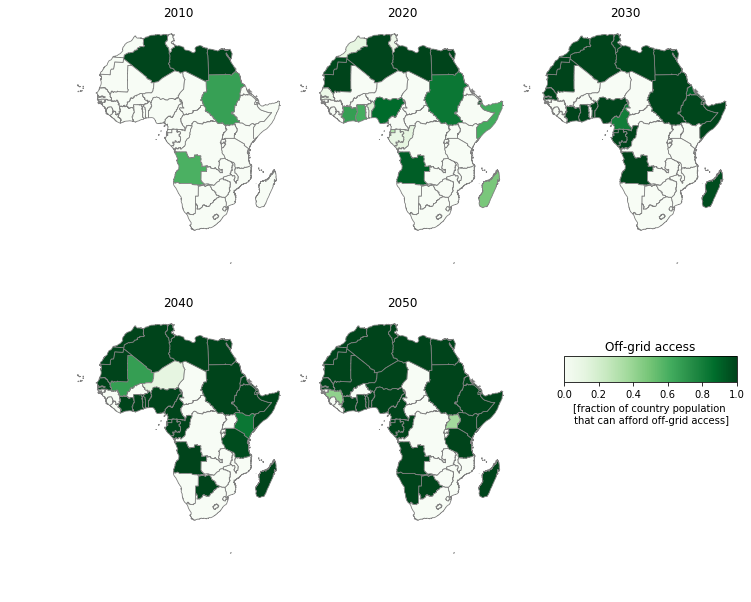

In [49]:
import matplotlib as mpl
fig = plt.figure()
fig.set_size_inches(12, 12)
fig.subplots_adjust(hspace=-0.2, wspace=0.0)
cmap = 'Greens'
vmin = 0
vmax = 1
cols = [c for c in wtp_offgrid.columns[-5:]]
for i in range(5):
    year = cols[i] #.split('_')[2]
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(year)
    wtp_offgrid.plot(ax=ax, column = cols[i], cmap = cmap, edgecolor='grey', linewidth=0.8,\
                     vmin=vmin, vmax=vmax)
cbax = fig.add_subplot(2, 3, 6)
cbax.set_position([0.70,0.40,0.20,0.03]) # [left, bottom, width, height]
cbax.set_title('Off-grid access')
cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax),
                               orientation='horizontal')
cb.set_label('[fraction of country population \n that can afford off-grid access]')

fig.savefig(gis_dir+'\\output\\access.png', dpi=150)


In [3]:
import gdal

In [4]:
# import the two rasters
pop_tot = gdal.Open(gis_dir+"\\pop_tot.tif")
pop_prj = gdal.Open(gis_dir+"\\pop_prj.tif")

In [5]:
# convert them first to arays, then to dataframes
tot = pd.DataFrame(pop_tot.ReadAsArray())
prj = pd.DataFrame(pop_prj.ReadAsArray())

In [6]:
# create normalized dataframe
norm = prj.astype(float)/tot.astype(float)
norm.head()

,0,1,2,3,4,5,6,7,8,9,...,8804,8805,8806,8807,8808,8809,8810,8811,8812,8813
0,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,...,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09
1,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,...,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09
2,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,...,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09
3,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,...,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09
4,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,...,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09,-2.147484e+09


In [7]:
# check that min and max are not infinity
n_max = norm.max().max()
n_min = norm.min().min()
print(n_min, n_max)

-2147483647.0 57155.0


So far we managed to create a normalized dataframe. We see that the minimum value is a large negative number (as expected), and the maximum value is a large positive number. The latter is not expected - it's a normalized layer, so we'd expect values <= 1. The reason why values greater than 1 occur has probably to do with the rasterization process (to create pop_tot). When a polygon border is crossing a pixel, during the rasterization the latter is either fully included or fully excluded in the polygon. What happens is that at the border of polygons certain pixels are excluded (i.e. assigned a value of 1), which are actually part of the country in pop_prj. We will correct for these directly in QGIS. 

Now we export the normalized dataframe to a raster file, weirdly named my_py.tif: 

In [23]:
# Import pop_tot in order to inherit all its attributes
data = gdal.Open(gis_dir+"\\pop_tot.tif", gdal.gdalconst.GA_ReadOnly)
geo_transform = data.GetGeoTransform()
prj = data.GetProjection()
x_min = geo_transform[0]
y_max = geo_transform[3]
x_max = x_min + geo_transform[1] * data.RasterXSize
y_min = y_max + geo_transform[5] * data.RasterYSize
x_res = data.RasterXSize
y_res = data.RasterYSize
pixel_width = geo_transform[1]

# define the array we want to use to create the new raster
array = np.array(norm)
# prepare an output tif with the inhereted properties
output = gis_dir+'\\my_py.TIF'
target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Float32)
target_ds.SetGeoTransform(geo_transform)
target_ds.SetProjection(prj)
# get the first (and only) band in the output raster
band = target_ds.GetRasterBand(1)
# assign a large negative number as NoDataValue
NoData_value = -999999
band.SetNoDataValue(NoData_value)
# write the array into the band and close everything
band.WriteArray(array)
band.FlushCache()
target_ds = None

Now we have a normalized population raster layer my_py.tif. It contains some large negative numbers and some values > 1. We switch back to QGIS to fix it - i.e. make all values lie between 0 and 1.  

In [24]:
alg = gdal.Open(gis_dir+"\\algeria.tif")
band = alg.GetRasterBand(1)

In [30]:
algdf = pd.DataFrame(alg.ReadAsArray())

In [36]:
val = 1
idx = []
for i in algdf.index:
    if algdf.loc[i,:].max() == val:
        idx.append(i)
col = []
for i in idx:    
    for c in algdf.columns:
        if algdf.loc[i,c] == val:
            col.append(c)
algdf.loc[idx,col]

,882
124,1.0


In [94]:
# failed attempt to rasterize in python using gdal
import gdal

ndsm = gis_dir+"\\pp_afr.TIF"
shp = gis_dir+'\\wtp_vec.shp'
data = gdal.Open(ndsm, gdal.gdalconst.GA_ReadOnly)
geo_transform = data.GetGeoTransform()
prj = data.GetProjection()
#source_layer = data.GetLayer()
x_min = geo_transform[0]
y_max = geo_transform[3]
x_max = x_min + geo_transform[1] * data.RasterXSize
y_min = y_max + geo_transform[5] * data.RasterYSize
x_res = data.RasterXSize
y_res = data.RasterYSize
mb_v = gdal.ogr.Open(shp)
mb_l = mb_v.GetLayer(0)
pixel_width = geo_transform[1]
output = gis_dir+'\\my_py.TIF'
target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Int32)
target_ds.SetGeoTransform(geo_transform)   #((x_min, pixel_width, 0, y_min, 0, pixel_width))
target_ds.SetProjection(prj)
band = target_ds.GetRasterBand(1)
NoData_value = 0
band.SetNoDataValue(NoData_value)
band.FlushCache()
gdal.RasterizeLayer(target_ds, [1], mb_l, options=["ATTRIBUTE='2010'"])

target_ds = None

In [15]:
wtp.a_pop_2010_sum

0     -3.326427e+12
1     -3.027861e+11
2     -5.798186e+10
3      0.000000e+00
4     -2.362232e+10
5     -4.294967e+09
6     -1.503239e+10
7      3.190000e+02
8     -6.442451e+09
9     -8.589935e+09
10    -6.442451e+09
11    -1.846936e+09
12     6.208646e-01
13    -1.528154e+09
14    -1.251531e+09
15    -1.096790e+09
16     0.000000e+00
17     1.925100e-01
18     0.000000e+00
19     0.000000e+00
20     0.000000e+00
21     0.000000e+00
22     0.000000e+00
23     0.000000e+00
24     0.000000e+00
25     0.000000e+00
26     0.000000e+00
27     0.000000e+00
28     0.000000e+00
29     0.000000e+00
           ...     
732    0.000000e+00
733    0.000000e+00
734    0.000000e+00
735    0.000000e+00
736    0.000000e+00
737    0.000000e+00
738    0.000000e+00
739    0.000000e+00
740    0.000000e+00
741    0.000000e+00
742    0.000000e+00
743    0.000000e+00
744    0.000000e+00
745    0.000000e+00
746    0.000000e+00
747    0.000000e+00
748    0.000000e+00
749    0.000000e+00
750    0.000000e+00
